<a href="https://colab.research.google.com/github/aquangnguyen1992/Advanced_Data_Science_Capstone/blob/master/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Get the dataset from Kaggle***

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
!kaggle competitions download -c ieee-fraud-detection
!unzip \*.zip  && rm *.zip

 84% 49.0M/58.3M [00:00<00:00, 55.0MB/s]
100% 58.3M/58.3M [00:00<00:00, 79.9MB/s]
 94% 49.0M/52.2M [00:00<00:00, 66.2MB/s]
100% 52.2M/52.2M [00:00<00:00, 106MB/s] 
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 218MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 99.7MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 76.6MB/s]
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  test_transaction.csv.zip
  inflating: test_transaction.csv    

Archive:  train_identity.csv.zip
  inflating: train_identity.csv      

Archive:  train_transaction.csv.zip
  inflating: train_transaction.csv   

Archive:  test_identity.csv.zip
  inflating: test_identity.csv       

5 archives were successfully processed.


# ***Analyzing the dataset and doing the cleansing***

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import copy
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
os.chdir("/content")
dataset_transaction = pd.read_csv('train_transaction.csv')
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
dataset_identity = pd.read_csv('train_identity.csv')
dataset_identity.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [4]:
dataset_identity.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [5]:
dataset_transaction.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

**Check NaN, Null, and OneHotEncoding**

In [6]:
float_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('O'))].to_list()

skip_int_columns = ['TransactionID', 'isFraud']
for column in skip_int_columns:
  int_columns.remove(column)

In [7]:
def normalization_data(X, indices):
  X_out = copy.copy(X)
  X_temp = X[indices]
  X_out.iloc[indices] = (X_temp-np.mean(X_temp))/(np.max(X_temp)-np.min(X_temp))
  X_out.iloc[np.where(np.isnan(X_out))[0]] = 0
  return np.min(X_temp), np.max(X_temp), np.mean(X_temp), X_out.astype('float16')

In [8]:
data_backup = copy.copy(dataset_transaction)
data_backup.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Task 1: Detect the columns with NaN and code it with an extra features
# Task 2: Apply normalizationn
# To-Do: Task 3: Remove the irrelevant columns

cache = dict()
dataset_transaction = copy.copy(data_backup)

#dataset_transaction.pop()

for column in float_columns:
  # Set to float 16
  dataset_transaction[column].astype('float16')

  # Code the NaN feature
  if np.any(np.isnan(dataset_transaction[column].values)):
    dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], dataset_transaction[column] = normalization_data(X, indices)

In [10]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300_NaN_Code,V301_NaN_Code,V302_NaN_Code,V303_NaN_Code,V304_NaN_Code,V305_NaN_Code,V306_NaN_Code,V307_NaN_Code,V308_NaN_Code,V309_NaN_Code,V310_NaN_Code,V311_NaN_Code,V312_NaN_Code,V313_NaN_Code,V314_NaN_Code,V315_NaN_Code,V316_NaN_Code,V317_NaN_Code,V318_NaN_Code,V319_NaN_Code,V320_NaN_Code,V321_NaN_Code,V322_NaN_Code,V323_NaN_Code,V324_NaN_Code,V325_NaN_Code,V326_NaN_Code,V327_NaN_Code,V328_NaN_Code,V329_NaN_Code,V330_NaN_Code,V331_NaN_Code,V332_NaN_Code,V333_NaN_Code,V334_NaN_Code,V335_NaN_Code,V336_NaN_Code,V337_NaN_Code,V338_NaN_Code,V339_NaN_Code
0,2987000,0,86400,-0.002083,W,13926,0.000000,-0.024384,discover,-0.418213,credit,0.055145,0.002167,-0.009674,0.0,NaN,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2987001,0,86401,-0.003321,W,2755,0.082886,-0.024384,mastercard,-0.709961,credit,0.077881,0.002167,0.000000,0.0,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2987002,0,86469,-0.002380,W,4663,0.254883,-0.024384,visa,-0.242920,debit,0.089233,0.002167,0.016388,0.0,outlook.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,2987003,0,86499,-0.002663,W,18132,0.408936,-0.024384,mastercard,-0.600586,debit,0.421143,0.002167,0.000000,0.0,yahoo.com,NaN,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,2987004,0,86506,-0.002663,H,4497,0.302979,-0.024384,mastercard,-0.709961,credit,0.293701,0.002167,0.000000,0.0,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
for column in int_columns:
  # Set to int 32
  dataset_transaction[column].astype('int32')

  # Code the NaN feature
  if np.any(np.isnan(dataset_transaction[column].values)):
    dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], dataset_transaction[column] = normalization_data(X, indices)

In [12]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300_NaN_Code,V301_NaN_Code,V302_NaN_Code,V303_NaN_Code,V304_NaN_Code,V305_NaN_Code,V306_NaN_Code,V307_NaN_Code,V308_NaN_Code,V309_NaN_Code,V310_NaN_Code,V311_NaN_Code,V312_NaN_Code,V313_NaN_Code,V314_NaN_Code,V315_NaN_Code,V316_NaN_Code,V317_NaN_Code,V318_NaN_Code,V319_NaN_Code,V320_NaN_Code,V321_NaN_Code,V322_NaN_Code,V323_NaN_Code,V324_NaN_Code,V325_NaN_Code,V326_NaN_Code,V327_NaN_Code,V328_NaN_Code,V329_NaN_Code,V330_NaN_Code,V331_NaN_Code,V332_NaN_Code,V333_NaN_Code,V334_NaN_Code,V335_NaN_Code,V336_NaN_Code,V337_NaN_Code,V338_NaN_Code,V339_NaN_Code
0,2987000,0,-0.463379,-0.002083,W,0.231445,0.000000,-0.024384,discover,-0.418213,credit,0.055145,0.002167,-0.009674,0.0,NaN,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2987001,0,-0.463379,-0.003321,W,-0.410645,0.082886,-0.024384,mastercard,-0.709961,credit,0.077881,0.002167,0.000000,0.0,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2987002,0,-0.463379,-0.002380,W,-0.301025,0.254883,-0.024384,visa,-0.242920,debit,0.089233,0.002167,0.016388,0.0,outlook.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,2987003,0,-0.463379,-0.002663,W,0.473389,0.408936,-0.024384,mastercard,-0.600586,debit,0.421143,0.002167,0.000000,0.0,yahoo.com,NaN,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,2987004,0,-0.463379,-0.002663,H,-0.310547,0.302979,-0.024384,mastercard,-0.709961,credit,0.293701,0.002167,0.000000,0.0,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
from sklearn.preprocessing import OneHotEncoder
for column in obj_columns:
  ohc = OneHotEncoder()
  dataset_transaction.loc[np.where(dataset_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.fit_transform(dataset_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(dataset_transaction[column].astype('str'))))])
  dataset_transaction = pd.concat([dataset_transaction, pd_encoded], axis=1)

for column in obj_columns:
  try:
    dataset_transaction.pop(column)
  except KeyError:
    pass
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,R_emaildomain_49,R_emaildomain_50,R_emaildomain_51,R_emaildomain_52,R_emaildomain_53,R_emaildomain_54,R_emaildomain_55,R_emaildomain_56,R_emaildomain_57,R_emaildomain_58,R_emaildomain_59,R_emaildomain_60,M1_0,M1_1,M1_2,M2_0,M2_1,M2_2,M3_0,M3_1,M3_2,M4_0,M4_1,M4_2,M4_3,M5_0,M5_1,M5_2,M6_0,M6_1,M6_2,M7_0,M7_1,M7_2,M8_0,M8_1,M8_2,M9_0,M9_1,M9_2
0,2987000,0,-0.463379,-0.002083,0.231445,0.000000,-0.024384,-0.418213,0.055145,0.002167,-0.009674,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.126709,-0.184814,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0
1,2987001,0,-0.463379,-0.003321,-0.410645,0.082886,-0.024384,-0.709961,0.077881,0.002167,0.000000,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,-0.141479,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0
2,2987002,0,-0.463379,-0.002380,-0.301025,0.254883,-0.024384,-0.242920,0.089233,0.002167,0.016388,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,-0.141479,0.232910,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,2987003,0,-0.463379,-0.002663,0.473389,0.408936,-0.024384,-0.600586,0.421143,0.002167,0.000000,0.0,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,0.0,0.0,0.0,0.0,-0.045654,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0
4,2987004,0,-0.463379,-0.002663,-0.310547,0.302979,-0.024384,-0.709961,0.293701,0.002167,0.000000,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0


In [14]:
print(np.any(np.isnan(dataset_transaction)), np.any(dataset_transaction.isnull()))

False False


# ***Creat the train/val dataset***

In [15]:
# Create a copy
dataset = copy.copy(dataset_transaction)

# Remove the irrelevant columns
dataset.pop('TransactionID')
dataset.head(5)

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,...,R_emaildomain_49,R_emaildomain_50,R_emaildomain_51,R_emaildomain_52,R_emaildomain_53,R_emaildomain_54,R_emaildomain_55,R_emaildomain_56,R_emaildomain_57,R_emaildomain_58,R_emaildomain_59,R_emaildomain_60,M1_0,M1_1,M1_2,M2_0,M2_1,M2_2,M3_0,M3_1,M3_2,M4_0,M4_1,M4_2,M4_3,M5_0,M5_1,M5_2,M6_0,M6_1,M6_2,M7_0,M7_1,M7_2,M8_0,M8_1,M8_2,M9_0,M9_1,M9_2
0,0,-0.463379,-0.002083,0.231445,0.000000,-0.024384,-0.418213,0.055145,0.002167,-0.009674,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.126709,-0.184814,0.0,0.0,0.0,-0.170166,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0
1,0,-0.463379,-0.003321,-0.410645,0.082886,-0.024384,-0.709961,0.077881,0.002167,0.000000,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,-0.141479,0.000000,0.0,0.0,0.0,-0.170166,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0
2,0,-0.463379,-0.002380,-0.301025,0.254883,-0.024384,-0.242920,0.089233,0.002167,0.016388,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,-0.141479,0.232910,0.0,0.0,0.0,0.157227,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,0,-0.463379,-0.002663,0.473389,0.408936,-0.024384,-0.600586,0.421143,0.002167,0.000000,0.0,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,0.0,0.0,0.0,0.0,-0.045654,0.000000,0.0,0.0,0.0,-0.054840,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0
4,0,-0.463379,-0.002663,-0.310547,0.302979,-0.024384,-0.709961,0.293701,0.002167,0.000000,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0


In [16]:
from sklearn.model_selection import train_test_split

Y = dataset['isFraud']
dataset.pop('isFraud')
X = dataset

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_train, axis=2)
print(X_train.shape, Y_train.shape, X_test.shape)

(472432, 903, 1) (472432,) (472432, 903, 1, 1)


**Check the imbalane of the train/test dataset**

Percentage of Fraud: 3.5%


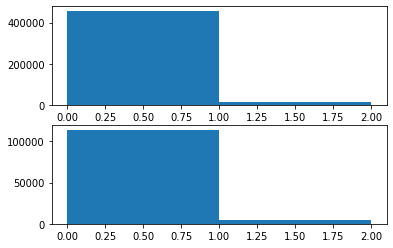

In [17]:
plt.subplot(211)
plt.hist(Y_train, bins=[0,1,2])

plt.subplot(212)
plt.hist(Y_test, bins=[0,1,2])

fraud_count = np.unique(Y_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

# ***The model using NN***

In [18]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD

In [19]:
def create_model(dense1=64, dense2=128, dropout_rate=0.4, l1_rate=0.001, l2_rate=0.001):
  out_model = Sequential()
  out_model.add(Dense(dense1, activation="relu", input_shape=(X_train.shape[1], 1),
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dense(dense1, activation="relu",
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(Dense(1, activation="sigmoid"))

  out_model.compile(
            optimizer=Adam(learning_rate=0.0003),
            loss='binary_crossentropy',
            metrics=['binary_accuracy'])
  
  return out_model

In [22]:
my_model = create_model(dense1=64)
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 903, 64)           128       
_________________________________________________________________
dense_4 (Dense)              (None, 903, 64)           4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 903, 64)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 903, 1)            65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
BATCH_SIZE = 1024
NB_EPOCH = 3

history = my_model.fit(X_train, Y_train, 
             batch_size=BATCH_SIZE, epochs=NB_EPOCH,
             validation_split=0.2, shuffle=True)

Epoch 1/3
210/370 [================>.............] - ETA: 6:04 - loss: 1.0422 - binary_accuracy: 0.9633

In [ ]:
plt.subplot(211)
plt.plot(history.history["loss"], '-b')
plt.plot(history.history["val_loss"], '-r')

plt.subplot(212)
plt.plot(history.history["binary_accuracy"], '-b')
plt.plot(history.history["val_binary_accuracy"], '-r')

**F1 validation (From https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model)**

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(Y_test, y_pred_bool))

# ***Debug zone***

In [ ]:
indices = np.where(np.isnan(a) == False)[0]
min_value, max_value, mean_value, normalized_data = normalization_data(a, indices)
print(min_value, max_value, mean_value, np.mean(normalized_data), np.min(normalized_data), np.max(normalized_data))
dataset_transaction['V331'] = normalized_data

0.0 160000.0 721.7418829164045 -2.2733716828843707e-16 -0.004510886768227528 0.9954891132317726


In [ ]:
dataset_transaction['V331']

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4        -0.004511
            ...   
590535    0.000000
590536    0.000000
590537    0.000000
590538    0.000000
590539    0.000000
Name: V331, Length: 590540, dtype: float64

**Train val dataset**